In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.utils import pretty_lat, pretty_lon, ProgressStatus, plot_n_steps_of_area_from_nc_file
from tempfile import TemporaryDirectory

In [2]:
from station.data_submission import DataSubmission
from station.station import StationData

from train_station_twin.training_executor import TrainingExecutor
from infilling.evaluation_executor import EvaluationExecutor
from infilling.infilling_writer import InfillingWriter

from era5.era5_for_station import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_download_hook import Era5DownloadHook
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
era5_hook = Era5DownloadHook(lat=0, lon=0)
era5_hook.coordinate_limits = {
    "north": 14.16443,
    "south": 12.16443,
    "west": -60.543,
    "east": -58.543
}

date = pd.Timestamp("2020-06-23")
folder = tempfile.TemporaryDirectory()
era5_target_file_path = f"{folder.name}/era5.nc"
era5_hook.download_hours_in_same_day(
    year=date.year,
    month=date.month,
    day=date.day,
    hours=[18,19,20],
    target_folder=folder.name
)
    

2024-07-26 12:01:18,583 INFO Welcome to the CDS
2024-07-26 12:01:18,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


using 327156 7efdcd6f-654c-45cc-aec3-1638dfa74a28


2024-07-26 12:01:18,718 INFO Request is completed
2024-07-26 12:01:18,718 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/adaptor.mars.internal-1721983959.5679212-31471-11-9f9ed2d0-74a5-4221-b2f1-fbaa70911d3c.grib to /var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmp42hq77i0/2020_6_23.grib (810)
2024-07-26 12:01:19,377 INFO Download rate 1.2K/s


Found 2020_6_23.grib
Renamed variable var167 to tas in /var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmp2lyf9011/2020_6_23.nc
Found 2020_6_23.nc
Merged era5 file saved into /var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmp42hq77i0/era5.nc
<xarray.Dataset> Size: 1kB
Dimensions:  (time: 3, lon: 9, lat: 9)
Coordinates:
  * time     (time) datetime64[ns] 24B 2020-06-23T18:00:00 ... 2020-06-23T20:...
  * lon      (lon) float64 72B 299.5 299.7 300.0 300.2 ... 301.0 301.2 301.5
  * lat      (lat) float64 72B 14.17 13.91 13.66 13.41 ... 12.66 12.41 12.16
Data variables:
    tas      (time, lat, lon) float32 972B ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Jul 26 12:01:26 2024: cdo mergetime /var/folders/lj/q1n...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...
displaying lon: 299.457
as -6

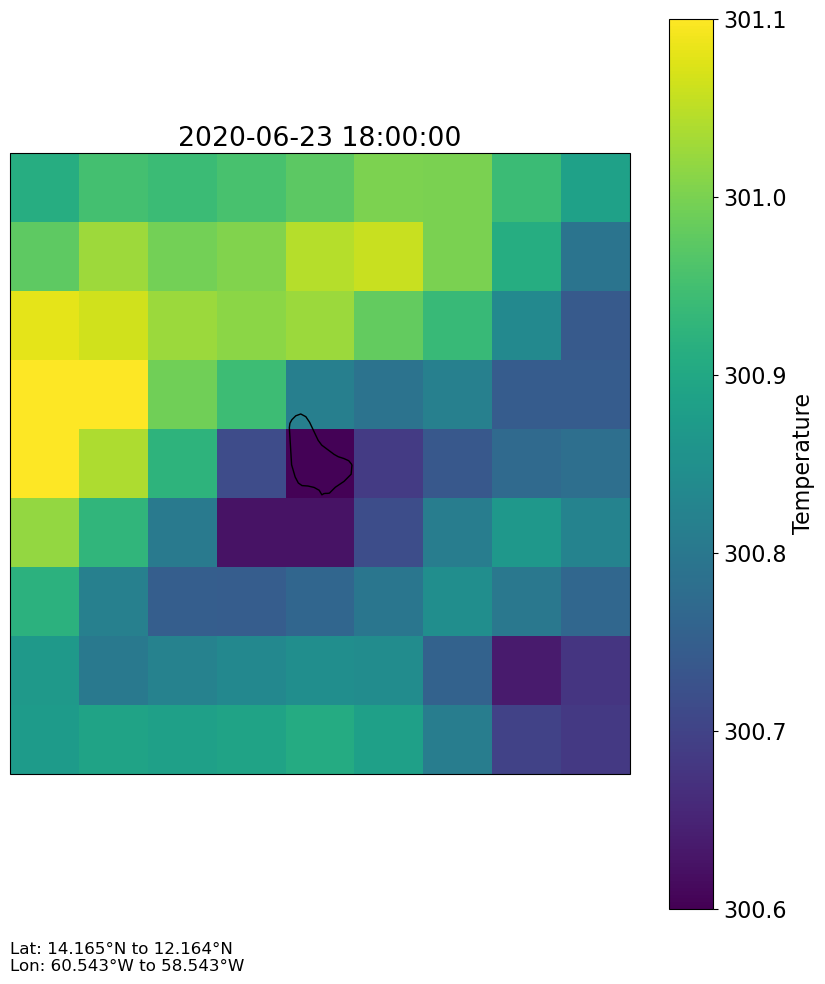

displaying lon: 299.457
as -60.543
displaying lon: 301.457
as -58.543


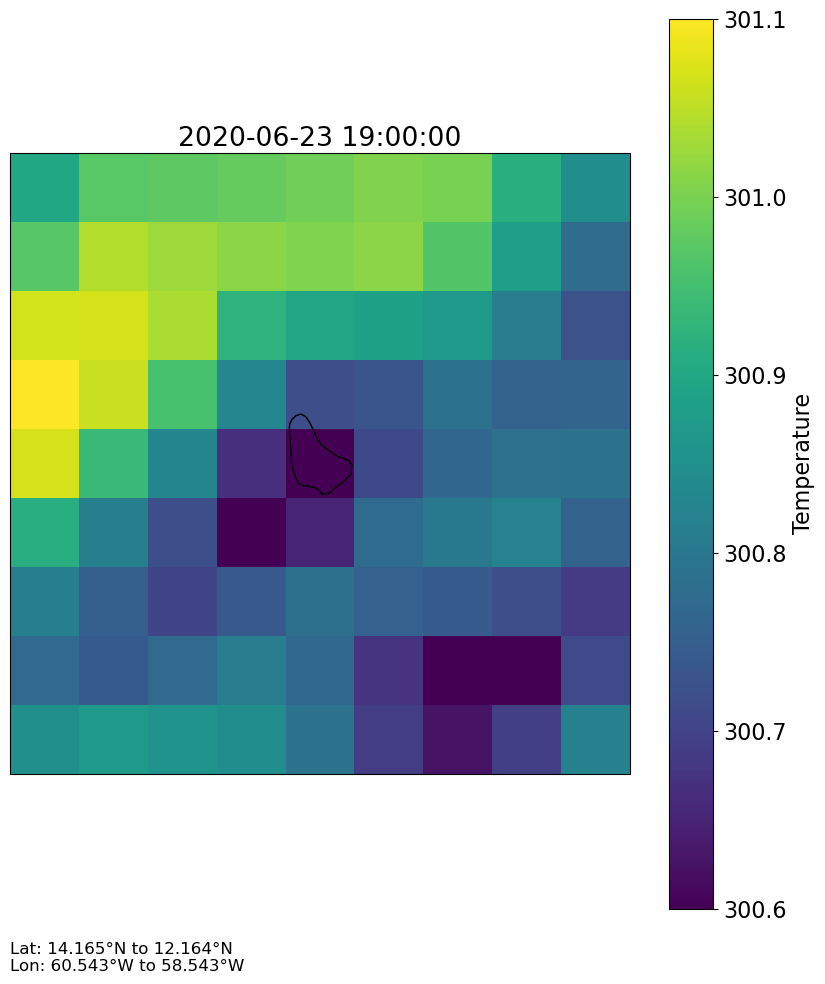

displaying lon: 299.457
as -60.543
displaying lon: 301.457
as -58.543


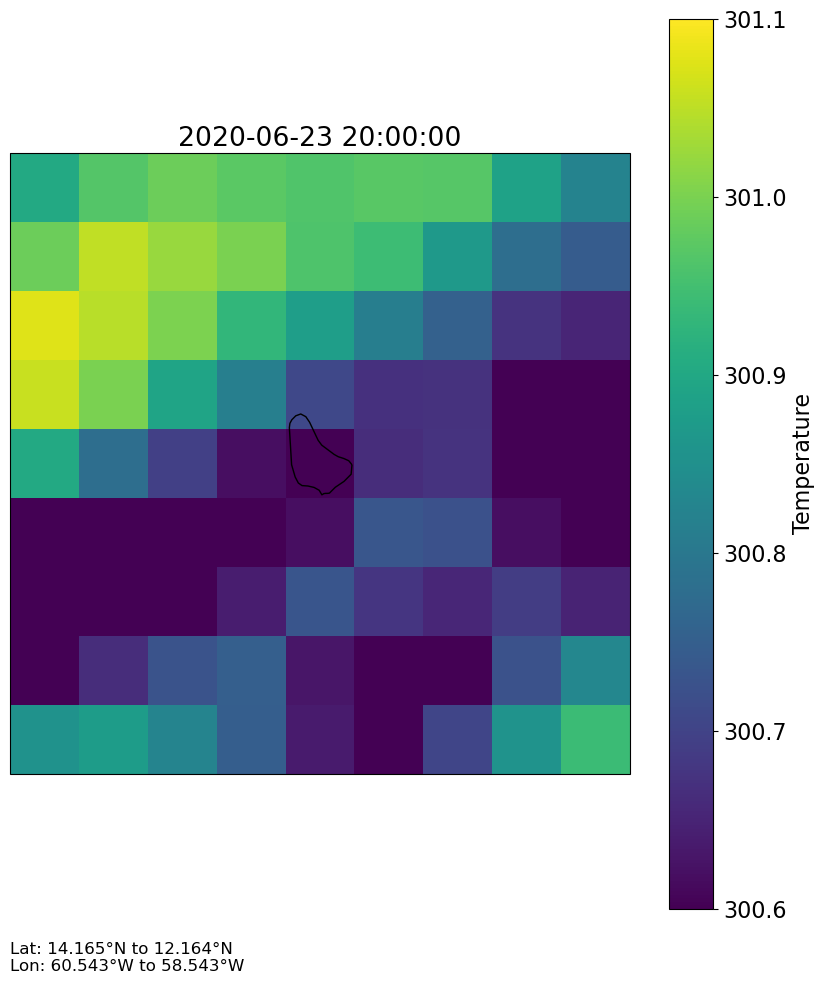

array([0, 1, 2])

In [5]:
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc


# conversion
Era5DataFromGribToNc(
    folder_path=folder.name,
    era5_target_file_path=era5_target_file_path
)


print(xr.open_dataset(era5_target_file_path))

# plot the data
plot_n_steps_of_area_from_nc_file(
    path=era5_target_file_path,
    n=3,
    vars="tas",
    title="ERA5 temperature",
    vmin=300.6,
    vmax=301.1
)

Extracting Barbados...


  0%|          | 0/1263 [00:00<?, ?it/s]

100%|██████████| 1263/1263 [01:42<00:00, 12.37it/s]
/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station/station.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_df = plot_df.reindex(pd.date_range(start=plot_df.index.min(),
/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station/station.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_df = plot_df.reindex(pd.date_range(start=plot_df.index.min(),


displaying lon: -59.54316
as -59.543


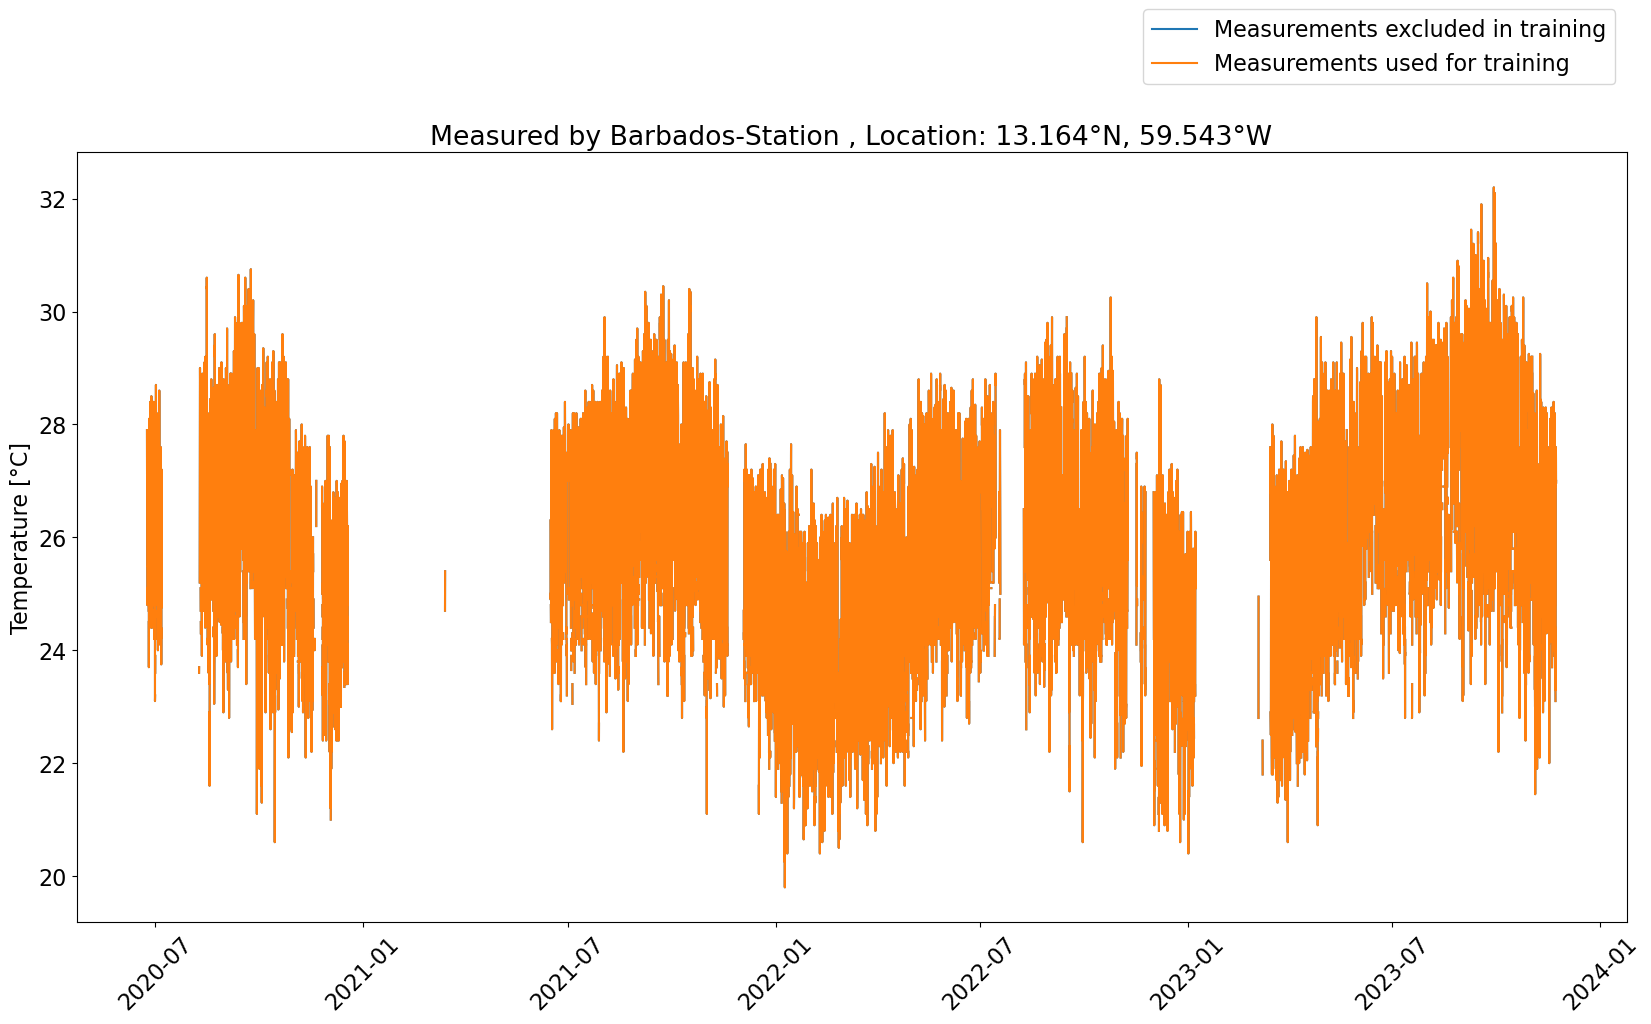

In [6]:
barbados_data = DataSubmission("Barbados")
barbados_data.measurement_dir_path = "./measurements/Barbados/"

barbados_station = StationData(
    name=barbados_data.name,
    folder_path=barbados_data.measurement_dir_path
)

In [92]:
from datetime import datetime


def load_and_process_dat_files(directory):
    def process_file(file_path):
        df = pd.read_csv(file_path, sep="\s+", header=0)
        df["datetime"] = df.apply(lambda row: datetime(int(row["year"]), int(row["mon"]), int(row["day"]), int(row["hour"]), int(row["min"])), axis=1)
        df = df.drop(columns=["year", "mon", "day", "hour", "min"])
        df = df.replace(-999.99, np.nan)
        return df

    all_dfs = []
    for file in os.listdir(directory):
        if file.endswith(".dat"):
            file_path = os.path.join(directory, file)
            df = process_file(file_path)
            all_dfs.append(df)
    
    combined_df = pd.concat(all_dfs).reset_index(drop=True)
    return combined_df

# Example usage
directory = "measurements/Barbados"
combined_df = load_and_process_dat_files(directory)

# Print column names
print(combined_df.columns)

combined_df.head()




Index(['bmp180_temp', 'bmp180_pres', 'bmp180_slp', 'bmp180_alt', 'bmp280_temp',
       'bmp280_pres', 'bmp280_slp', 'bmp280_alt', 'bme_temp', 'bme_pres',
       'bme_slp', 'bme_alt', 'bme_hum', 'htu_temp', 'htu_hum', 'mcp9808',
       'tipping', 'vis_light', 'ir_light', 'uv_light', 'wind_dir',
       'wind_speed', 'datetime'],
      dtype='object')


,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,...,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed,datetime
0,NaN,NaN,NaN,NaN,24.85,729.19,752.39,274.0,NaN,NaN,...,23.9,84.7,NaN,0.0,260.0,253.0,2.0,NaN,2.95,2021-01-27 00:00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,261.0,252.0,2.0,NaN,2.96,2021-01-27 00:01:00
2,NaN,NaN,NaN,NaN,24.85,729.19,752.39,274.0,NaN,NaN,...,23.9,84.6,23.8,0.0,259.0,253.0,1.0,NaN,3.42,2021-01-27 00:02:00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23.8,0.0,261.0,251.0,2.0,NaN,2.55,2021-01-27 00:03:00
4,NaN,NaN,NaN,NaN,24.85,729.19,752.39,274.0,NaN,NaN,...,23.9,84.3,23.8,0.0,261.0,254.0,2.0,NaN,2.79,2021-01-27 00:04:00


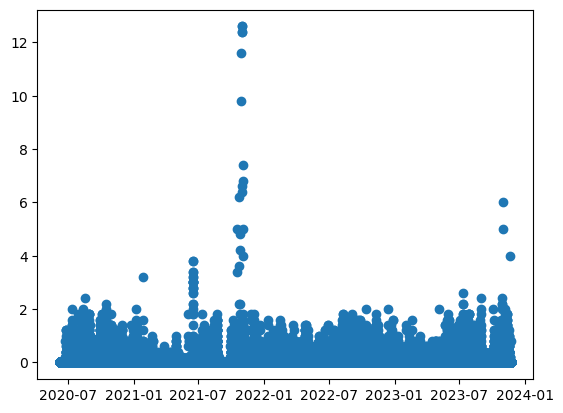

In [94]:
plt.plot(combined_df["datetime"], combined_df["tipping"], marker="o", linestyle="None")


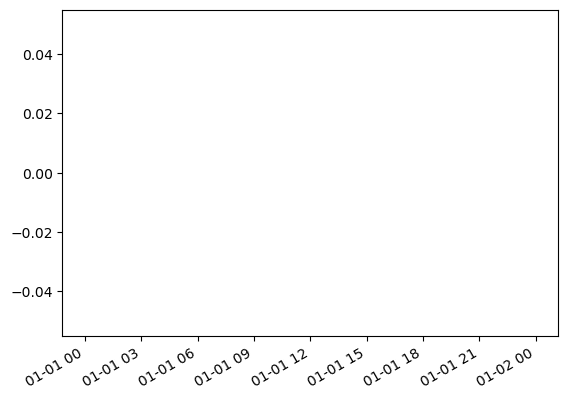

In [93]:
start = "2017-01-01"
end = "2019-12-31"

filtered_df = combined_df[(combined_df["datetime"] >= start) & (combined_df["datetime"] <= end)]

plt.plot(filtered_df["datetime"], filtered_df["tipping"], marker="o", linestyle="None")

plt.gcf().autofmt_xdate()

In [95]:
filtered_df1 = combined_df[combined_df["tipping"].notna()]
print(filtered_df1.shape)

filtered_df2 = combined_df[(combined_df["tipping"] != 0.0) & (combined_df["tipping"].notna())]
print(filtered_df2.shape)

print(combined_df.shape)


(1738321, 23)
(16470, 23)
(1817508, 23)


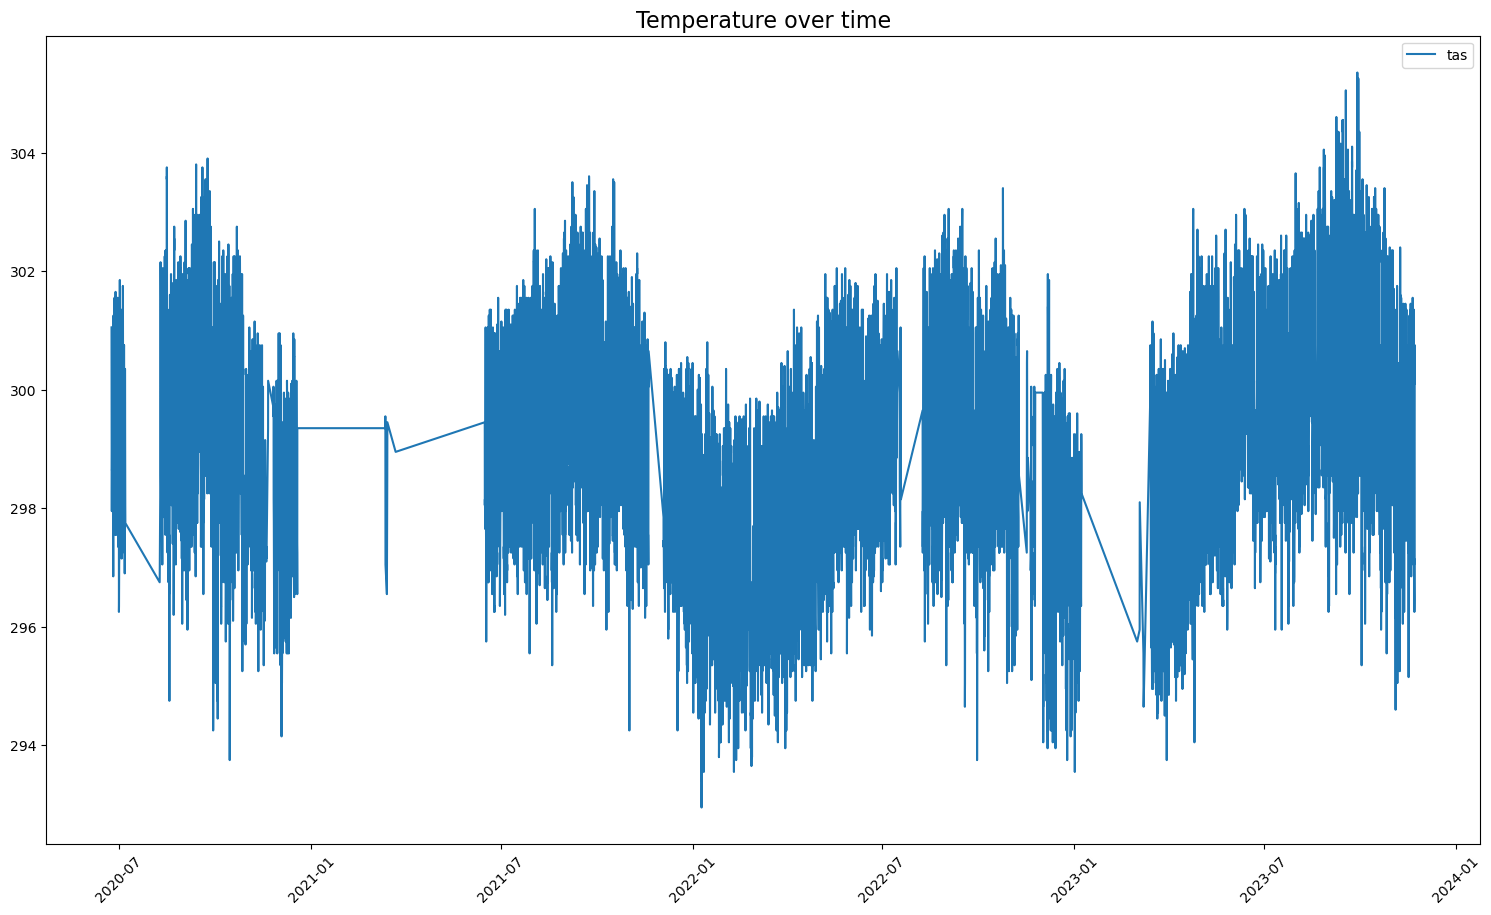

In [8]:

from utils.utils import plot_measurements_df
plot_measurements_df(barbados_station.df)

**Plot a few random timesteps of the weather station:**

Extracting Marshall...


100%|██████████| 2465/2465 [03:17<00:00, 12.50it/s]
/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station/station.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_df = plot_df.reindex(pd.date_range(start=plot_df.index.min(),
/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station/station.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_df = plot_df.reindex(pd.date_range(start=plot_df.index.min(),


displaying lon: -105.196
as -105.196


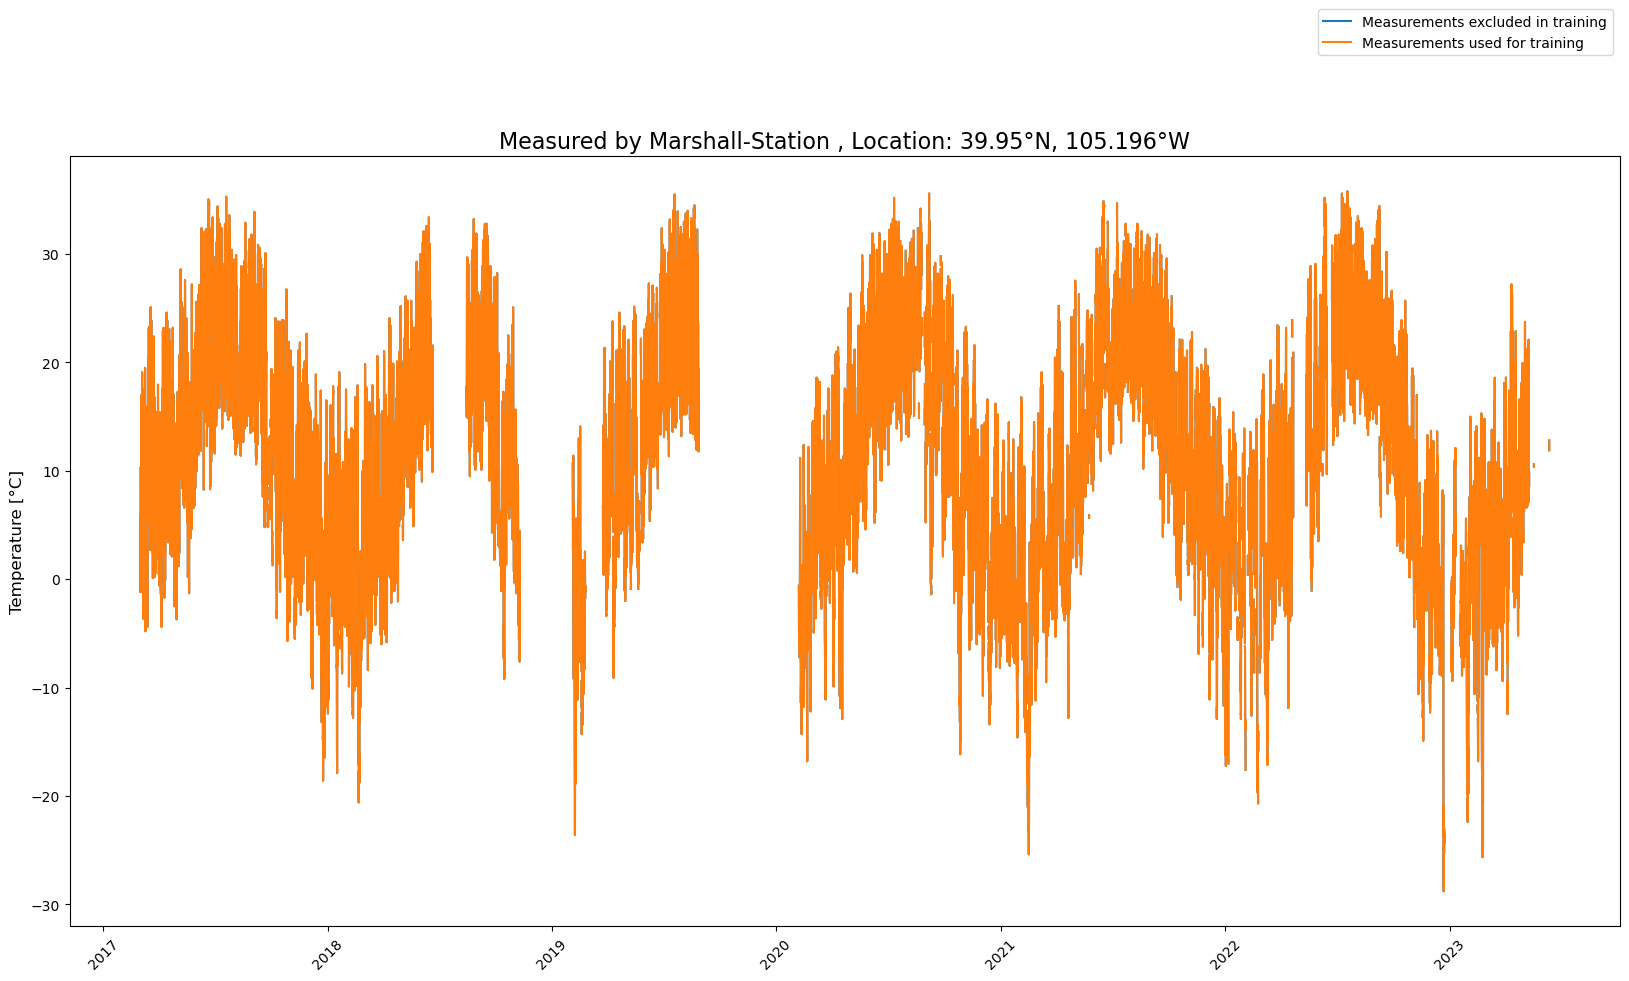

Extracting Vienna...


100%|██████████| 1857/1857 [02:43<00:00, 11.36it/s]
/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station/station.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_df = plot_df.reindex(pd.date_range(start=plot_df.index.min(),
/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station/station.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_df = plot_df.reindex(pd.date_range(start=plot_df.index.min(),


displaying lon: 16.3609
as 16.361


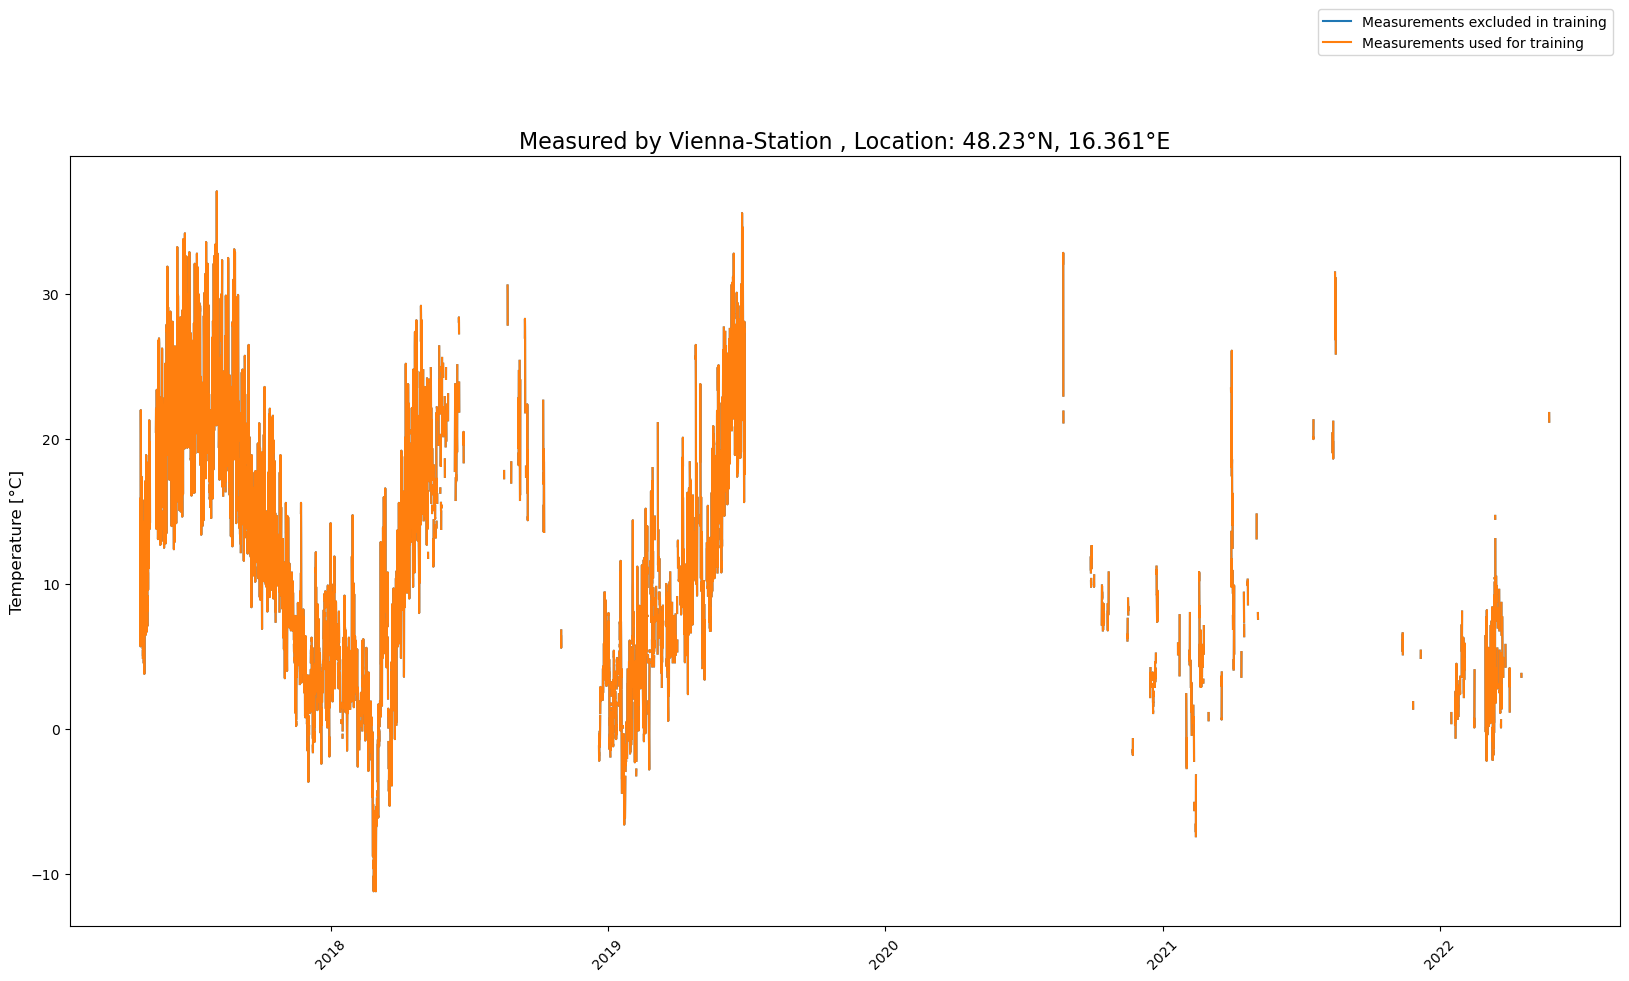

In [9]:
marshall_station = StationData("Marshall", "./measurements/Marshall/")
vienna_station = StationData("Vienna", "./measurements/Vienna/")

In [10]:
st = "executed_trainings/Vienna_20240522-1659/target_9gs0g5n6/train/vienna.nc"
e5 = "executed_trainings/Vienna_20240522-1659/target_9gs0g5n6/train/era5_merged.nc"

dst = xr.open_dataset(st)
de5 = xr.open_dataset(e5)

plt.plot(station_submission.station.df.index, station_submission.station.df["tas"], label="station")
plt.plot(de5["time"], de5["tas"].mean(axis=(1,2)), label="era5")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/executed_trainings/Vienna_20240522-1659/target_9gs0g5n6/train/vienna.nc'

In [7]:
from station.dat_to_nc_convertercopy  import DatToNcConverter

directory = "measurements/Vienna"
converter = DatToNcConverter(name="Vienna_", directory=directory, target_directory="measurements/Vienna_extracted")
converter.execute()

Extracting Vienna...


100%|██████████| 1857/1857 [04:52<00:00,  6.35it/s]


Saving to /Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station_data_as_nc/vienna.nc


PermissionError: [Errno 13] Permission denied: '/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/station_data_as_nc/vienna.nc'